In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sns.set()

In [3]:
path = './archive1/dataset.txt'

df = pd.read_csv(path)

df.head()

date     value
0  1991-07-01  3.526591
1  1991-08-01  3.180891
2  1991-09-01  3.252221
3  1991-10-01  3.611003
4  1991-11-01  3.565869

In [4]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(df.value.dropna(inplace=False))

print(f"ADF Statistic: %f" % result[0])
print(f"p-value: %f" % result[1])

ADF Statistic: 3.145186
p-value: 1.000000


<Figure size 2000x1000 with 0 Axes>

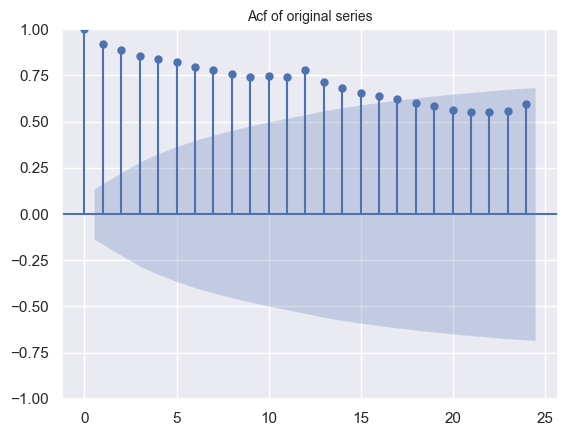

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plot_acf(df.value)
plt.title('Acf of original series', size=10)

plt.show()

In [6]:
def autocorrelation(array, lag):
    num = 0
    den = 0
    x_bar = np.mean(array)
    array = array[::-1]
    for i in range(len(array)-lag-1):
        num += np.sum((array[i] - x_bar) * (array[i+lag] - x_bar))
        den += np.sum((array[i] - x_bar)**2)
    return num/den

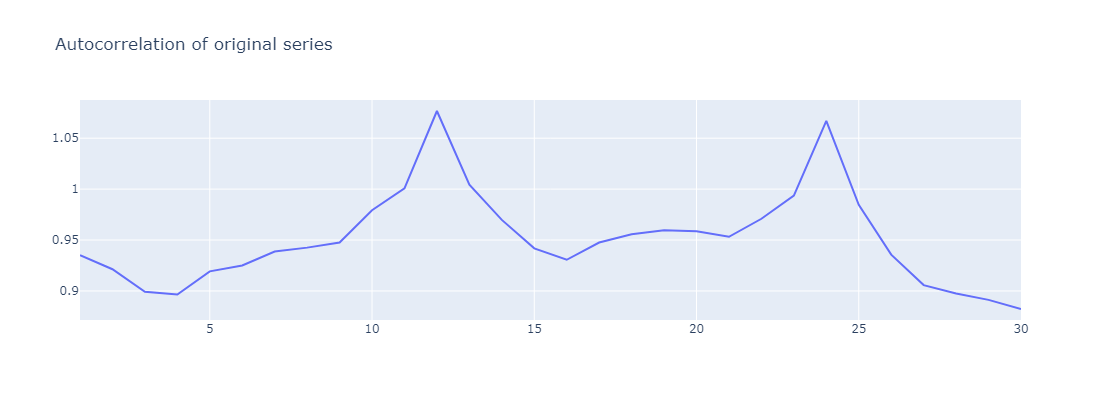

In [7]:
go.Figure(data=go.Scatter(x=[i for i in range(1,31)], y=[autocorrelation(df.value, i) for i in range(1,31)]), layout=go.Layout(title='Autocorrelation of original series', width=800, height=400)).show()

<Figure size 2000x1000 with 0 Axes>

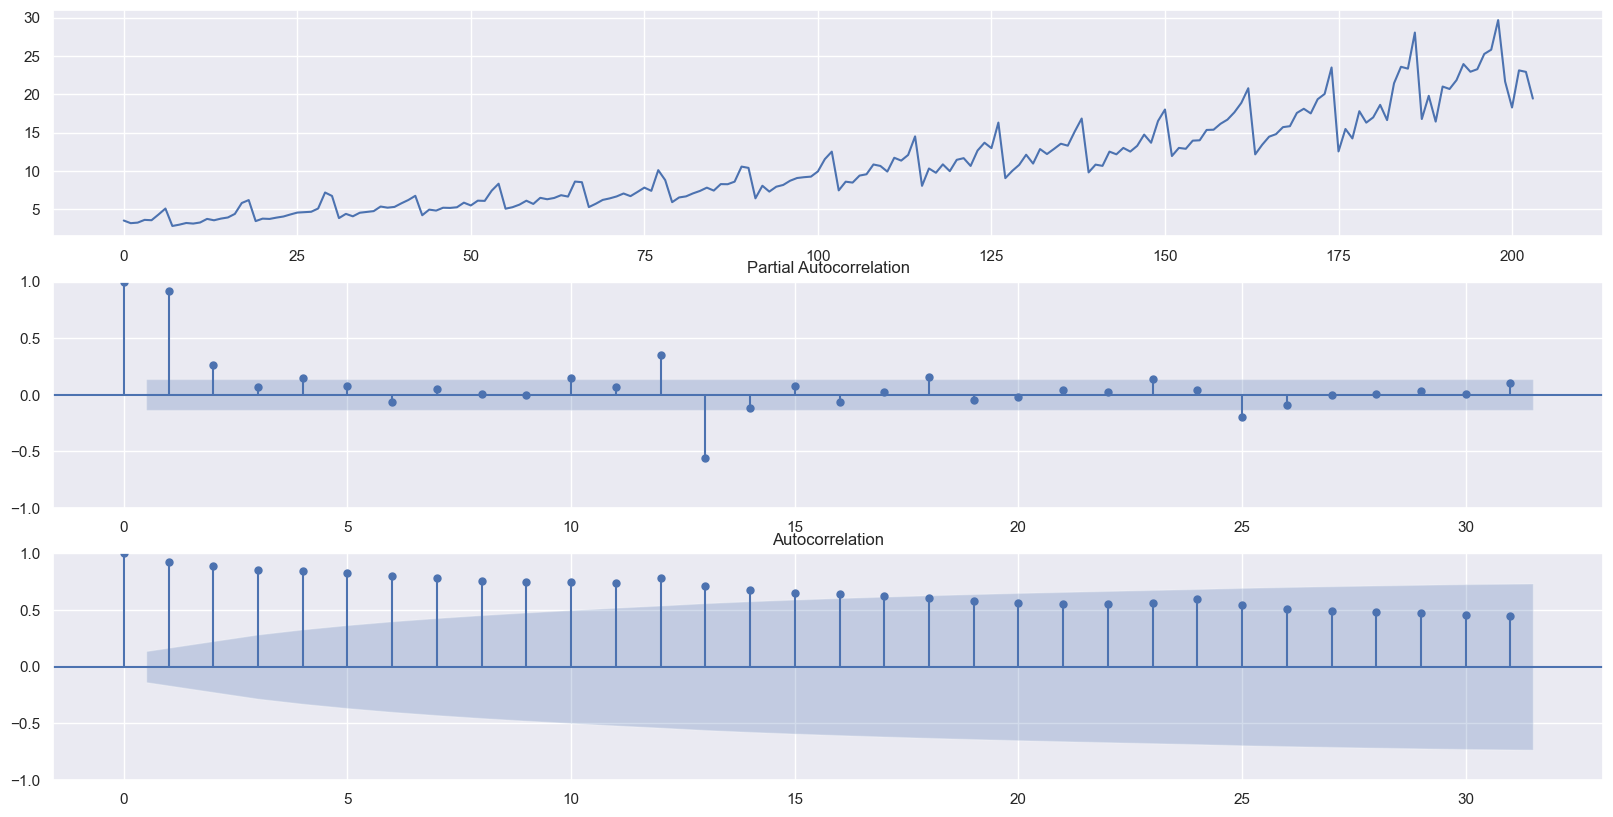

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(20,10))
fig, ax = plt.subplots(3,1,figsize=(20,10))
ax[0].plot(df.value)
plot_acf(df.value.dropna(), ax = ax[2], lags = 31)
plot_pacf(df.value.dropna(), ax = ax[1], lags = 31)
plt.show()

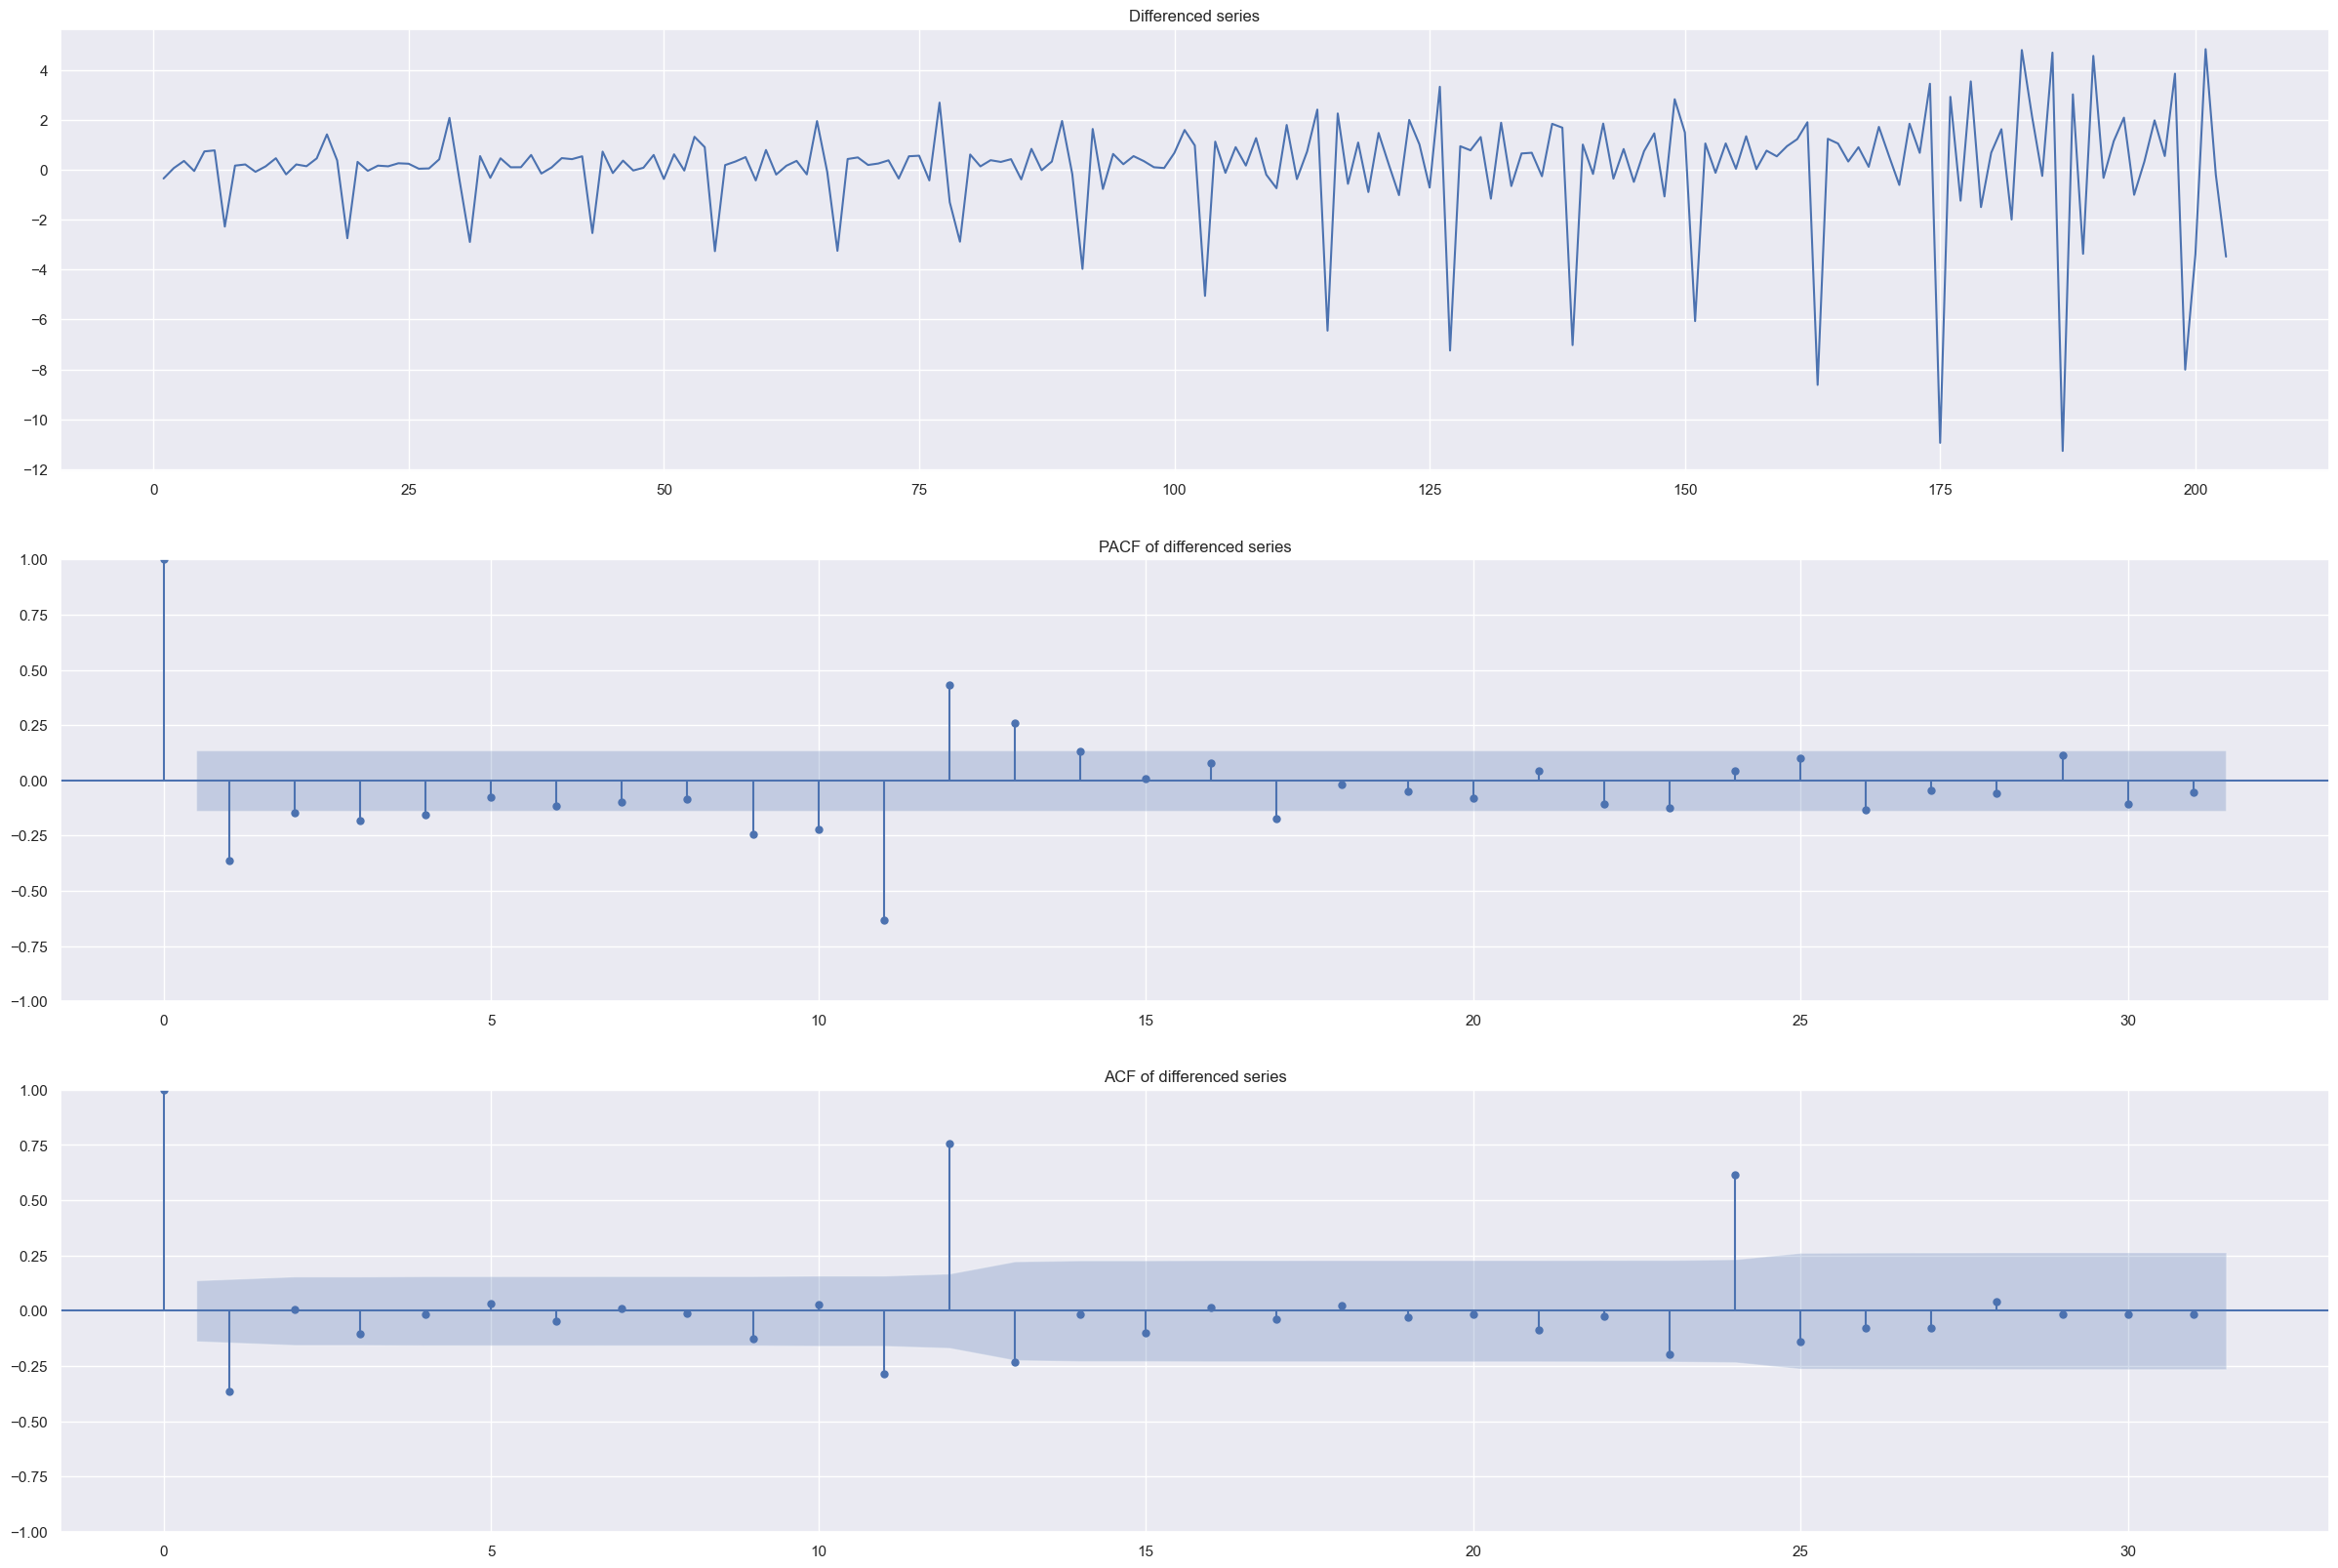

In [9]:
fig, ax = plt.subplots(3,1,figsize=(30,20))
ax[0].plot(df.value.diff())
plot_acf(df.value.diff().dropna(), ax = ax[2], lags = 31)
plot_pacf(df.value.diff().dropna(), ax = ax[1], lags = 31, method='ywmle')
ax[0].set_title('Differenced series')
ax[1].set_title('PACF of differenced series')
ax[2].set_title('ACF of differenced series')
plt.show()

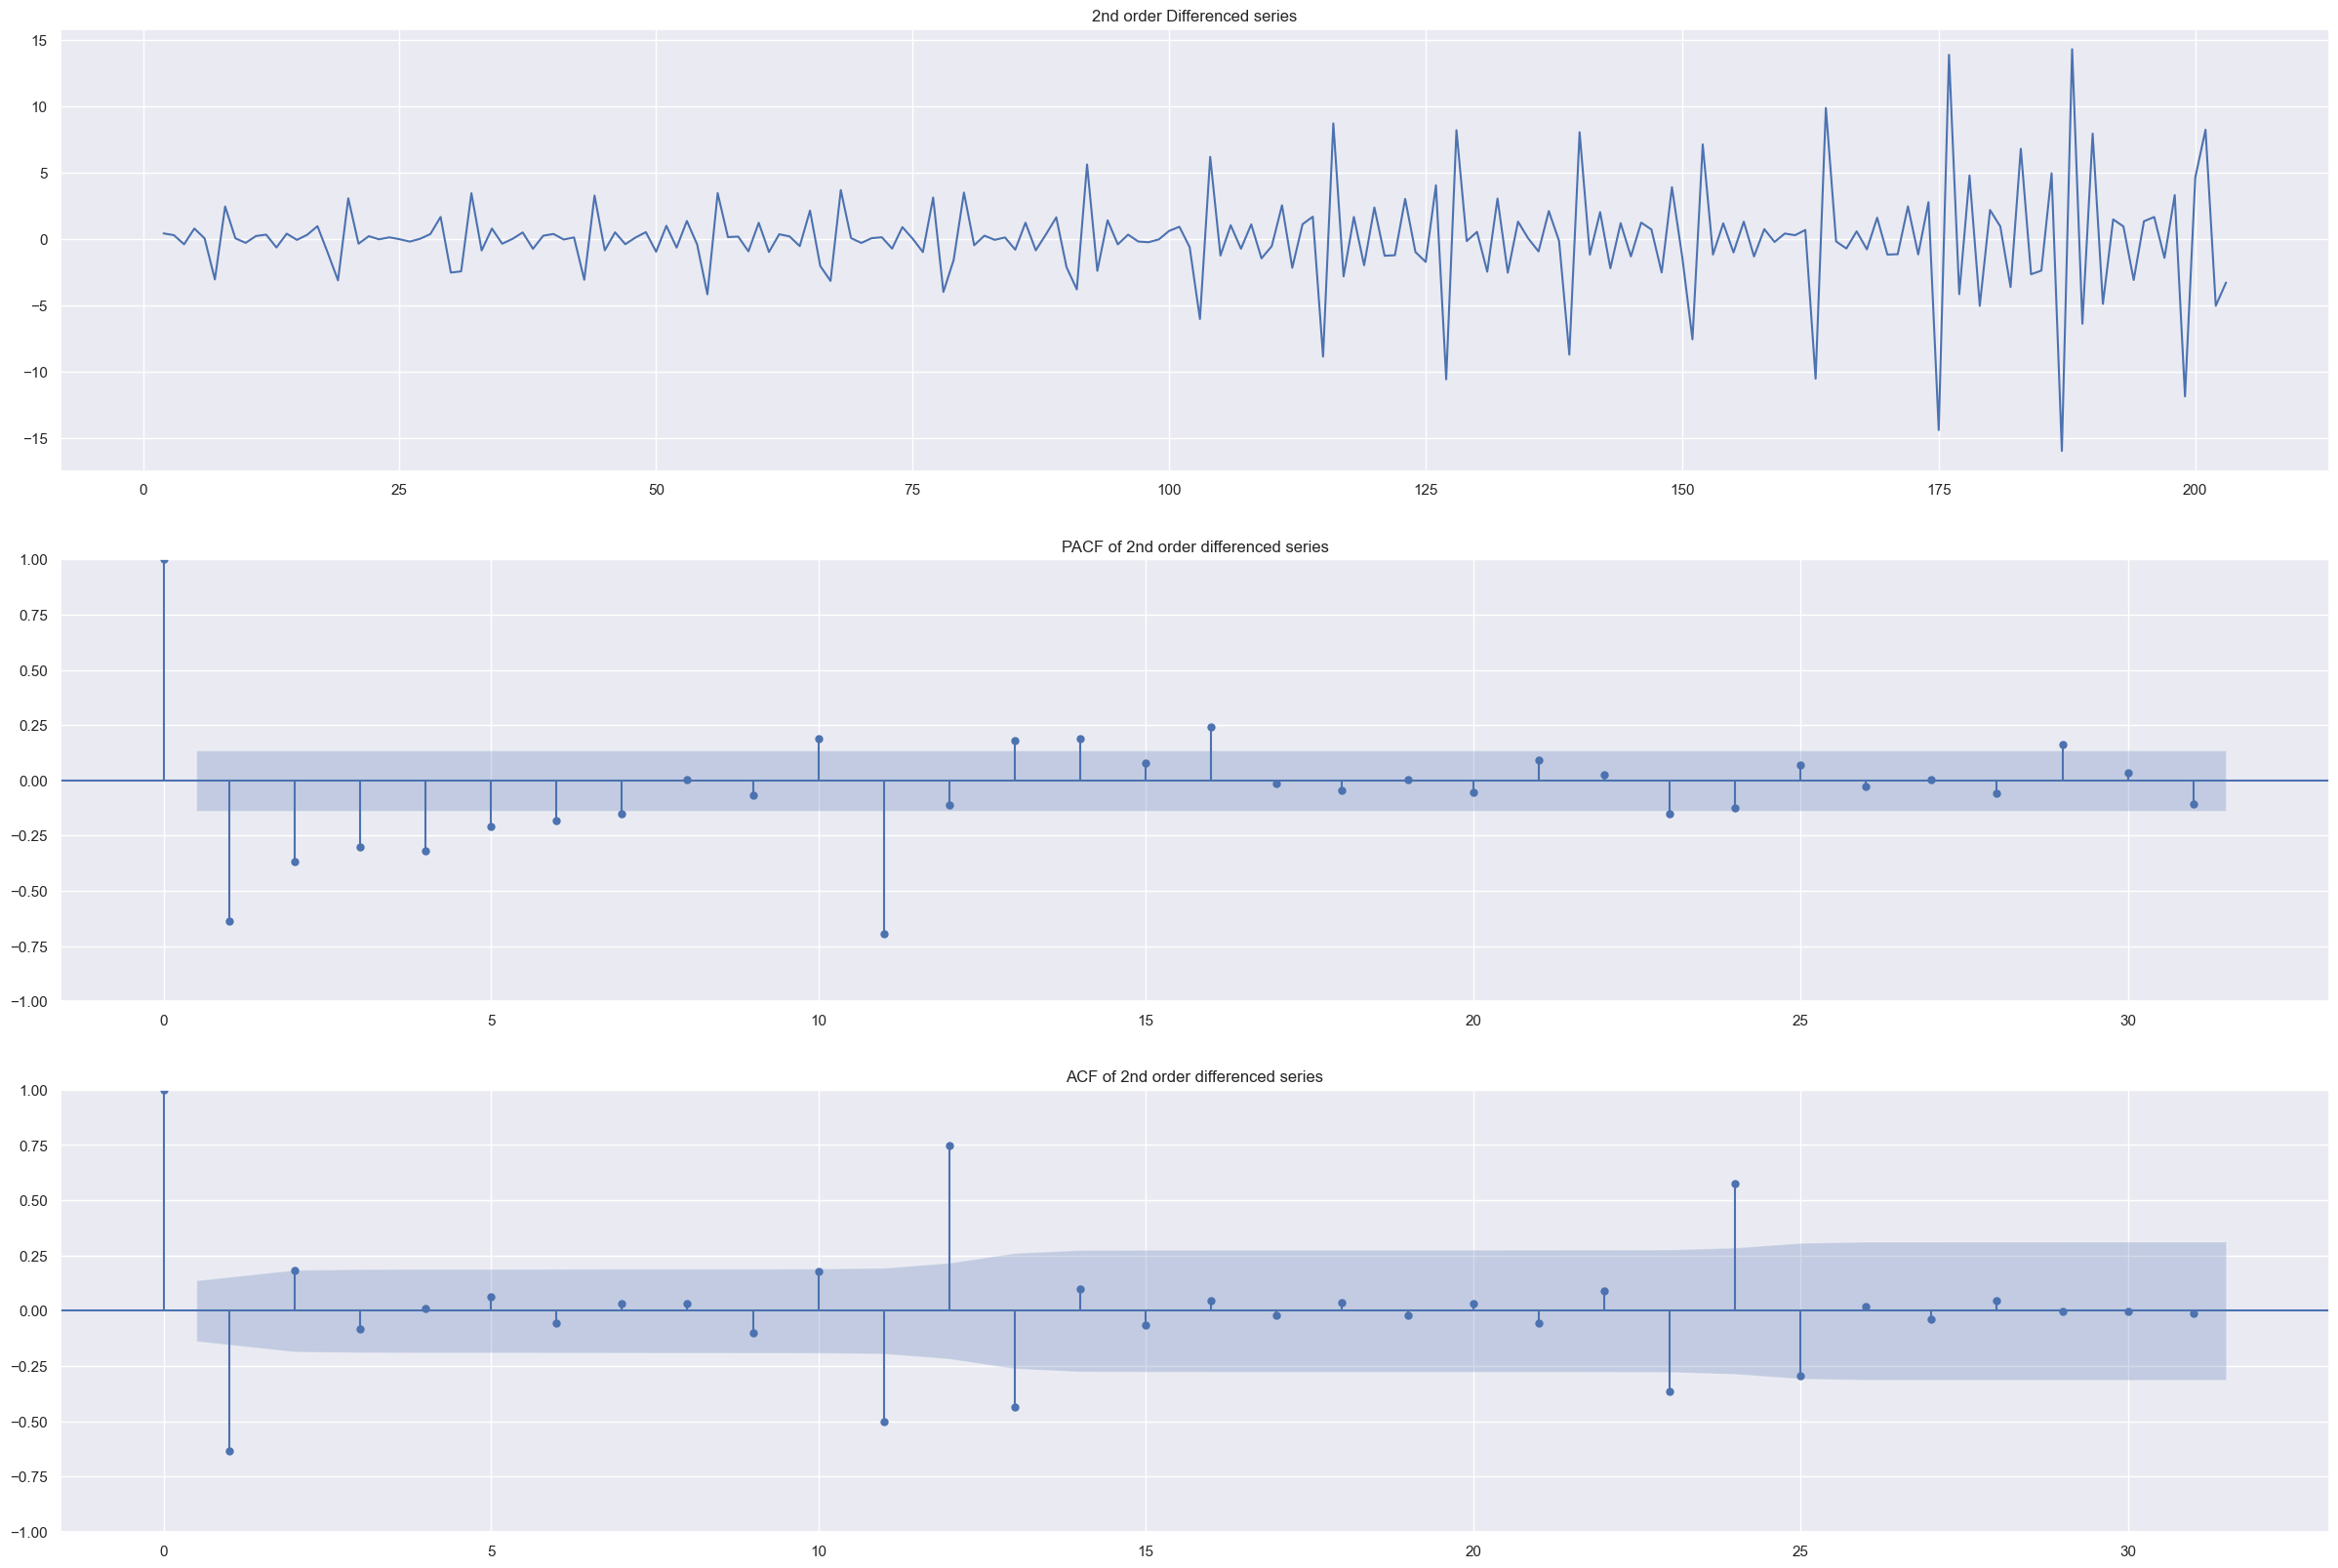

In [10]:
fig, ax = plt.subplots(3,1,figsize=(30,20))
ax[0].plot(df.value.diff().diff())
plot_acf(df.value.diff().diff().dropna(), ax = ax[2], lags = 31)
plot_pacf(df.value.diff().diff().dropna(), ax = ax[1], lags = 31, method='ywmle')
ax[0].set_title('2nd order Differenced series')
ax[1].set_title('PACF of 2nd order differenced series')
ax[2].set_title('ACF of 2nd order differenced series')
plt.show()

[]

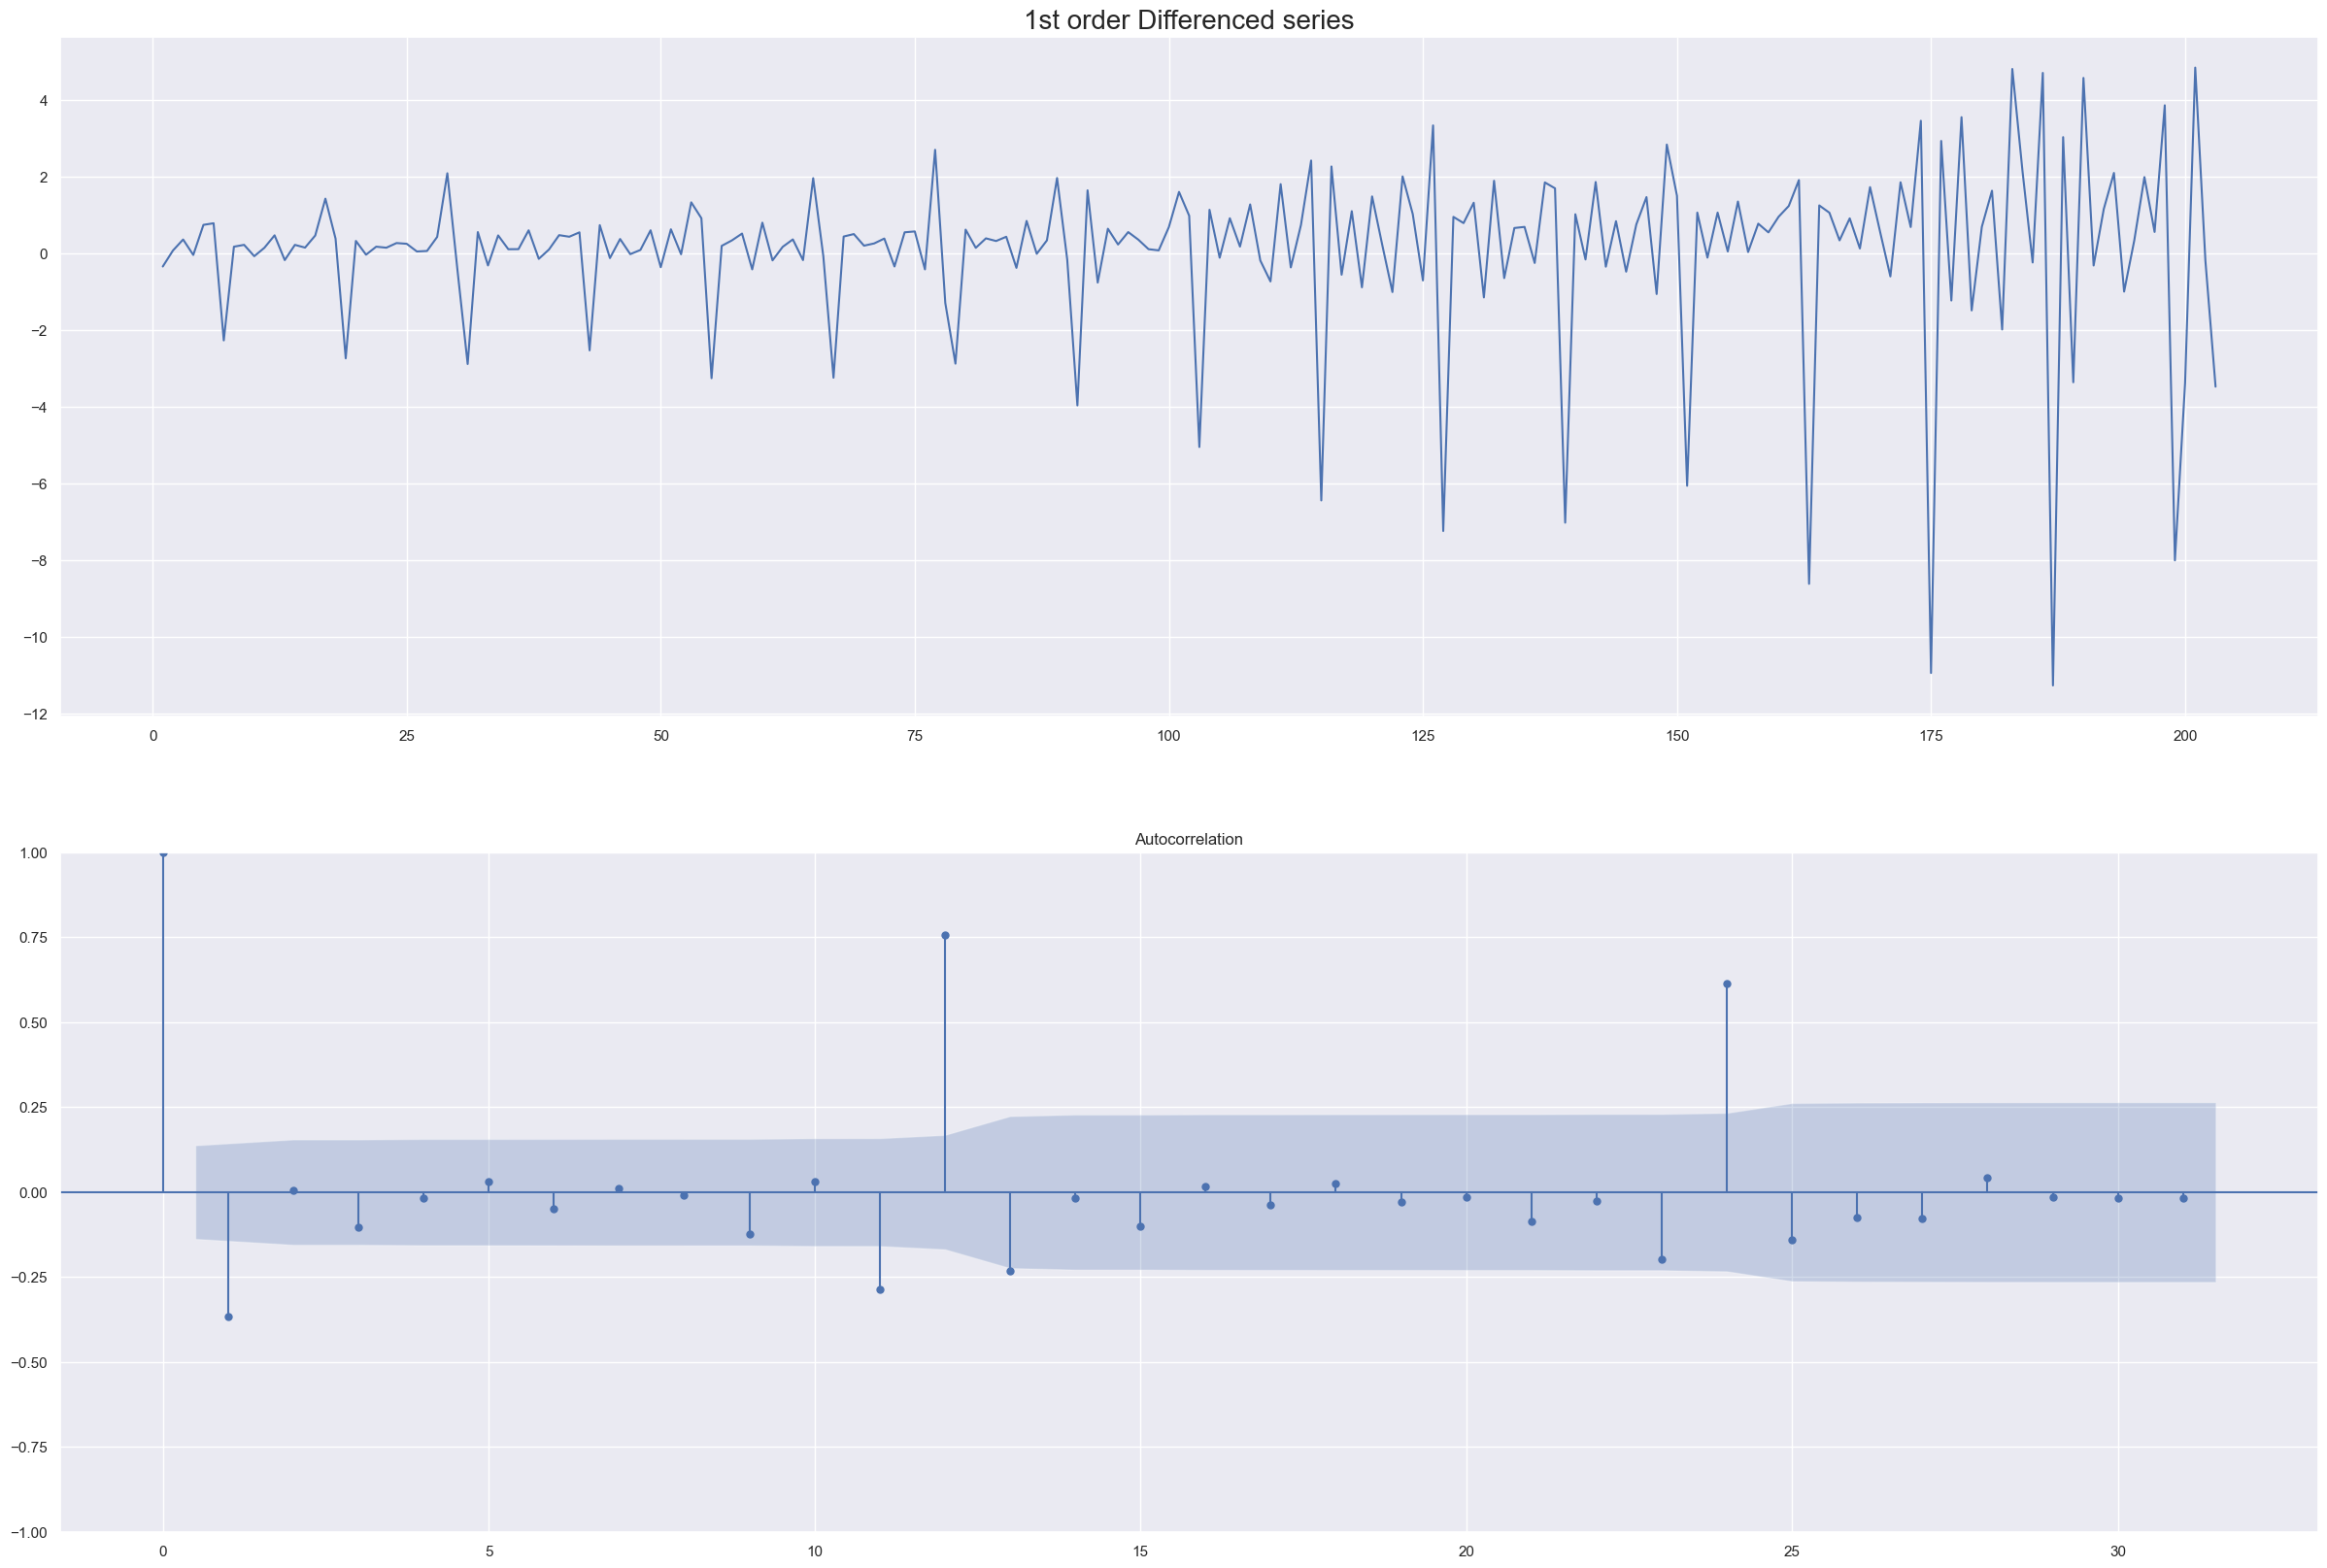

In [11]:
fig, ax = plt.subplots(2,1,figsize=(30,20))
ax[0].plot(df.value.diff().dropna(), label='1st order')
plot_acf(df.value.diff().dropna(), ax = ax[1], lags = 31)

ax[0].set_title('1st order Differenced series', size =20)
plt.plot()

In [12]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -424.570
Date:                Thu, 08 Feb 2024   AIC                            857.140
Time:                        13:05:42   BIC                            870.393
Sample:                             0   HQIC                           862.502
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4178      0.356      1.174      0.240      -0.280       1.115
ma.L1         -0.9546      0.377     -2.531      0.011      -1.694      -0.215
ma.L2          0.0969      0.272      0.356      0.7

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -424.762
Date:                Thu, 08 Feb 2024   AIC                            855.524
Time:                        13:05:43   BIC                            865.463
Sample:                             0   HQIC                           859.545
                                - 204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3009      0.094      3.195      0.001       0.116       0.485
ma.L1         -0.8300      0.048    -17.204      0.000      -0.925      -0.735
sigma2         3.8327      0.259     14.790      0.0

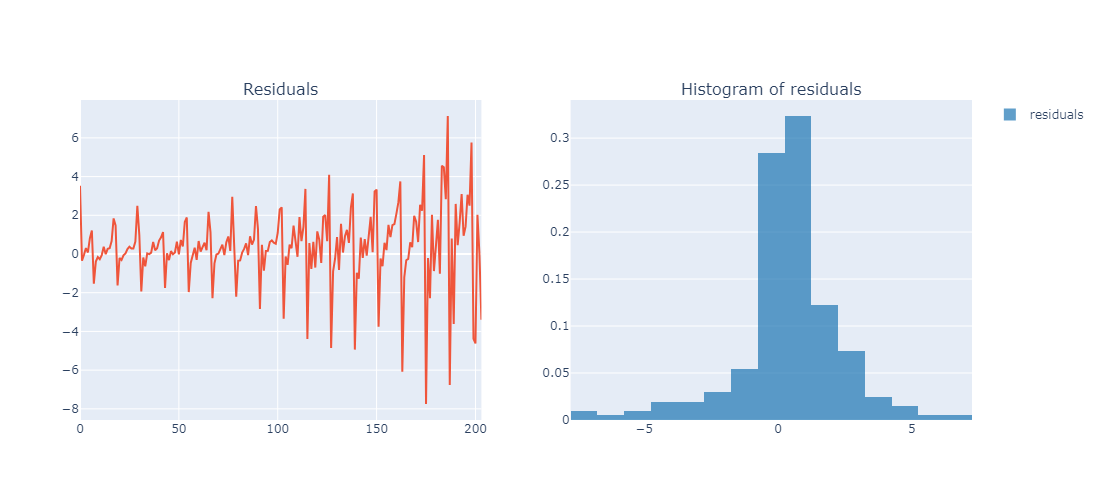

In [14]:
import plotly.figure_factory as ff
df_resid = pd.DataFrame(model_fit.resid, columns=['residuals'])

fig1 = ff.create_distplot([df_resid.residuals], ['residuals'], ['KDE Plot'], histnorm='probability density')
fig2 = go.Figure(go.Scatter(x=df_resid.index, y=df_resid.residuals, name='Residuals', showlegend=False))

fig = make_subplots(rows=1, cols=2, subplot_titles=('Residuals', 'Histogram of residuals'))
fig.add_trace(fig1['data'][0], row=1, col=2)
fig.add_trace(fig2['data'][0], row=1, col=1)

fig.update_layout(height=500, width=1000)
fig.show()

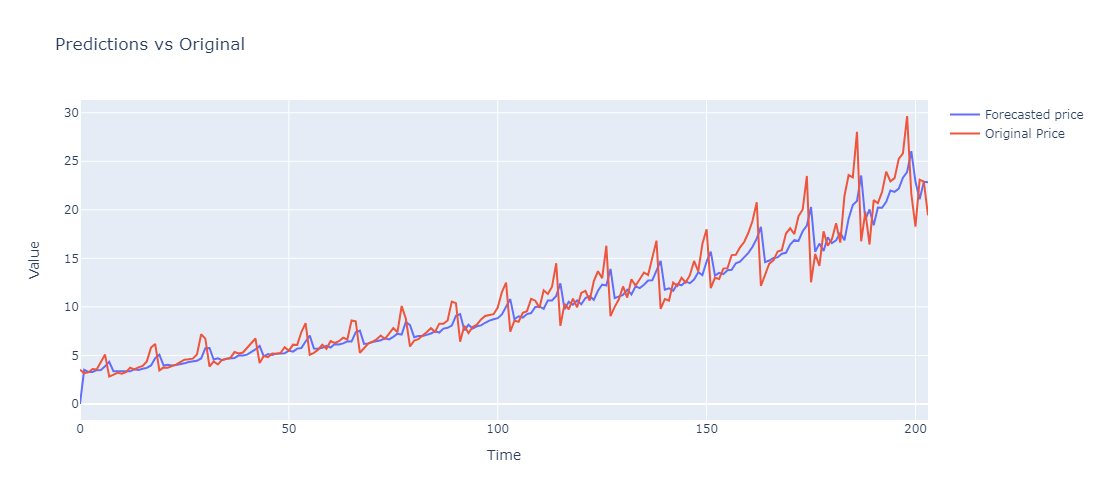

In [15]:
df_pred = pd.DataFrame(model_fit.predict(dynamic=False).values, columns=['predictions'])
np.array(df_pred.index)

fig= go.Figure()
fig.add_trace(go.Scatter(x=df_pred.index, y=df_pred.predictions, name='Forecasted price'))
fig.add_trace(go.Scatter(x=df.index, y=df.value, name='Original Price'))

fig.update_layout(
    height=500, 
    width=1000,
    title='Predictions vs Original',
    xaxis_title='Time',
    yaxis_title='Value')
fig.show()

In [16]:
train = df.value[:85]
test = df.value[85:]

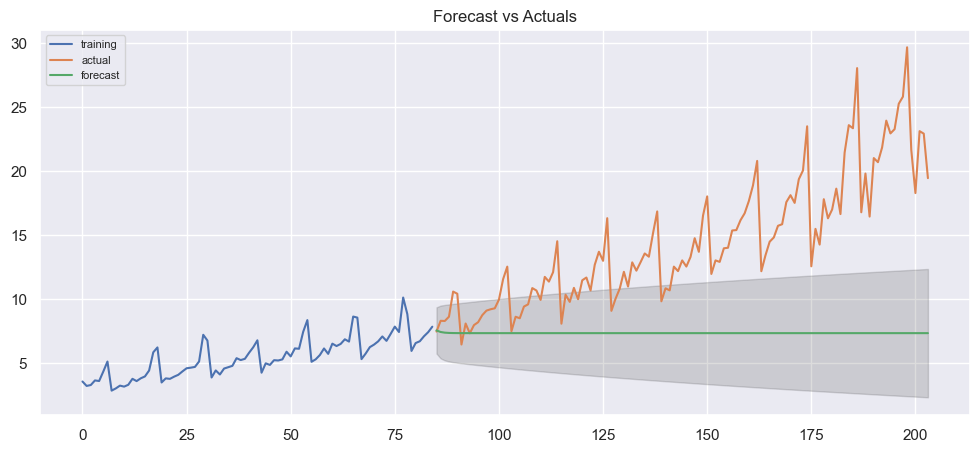

In [17]:
# Build Model
model = ARIMA(train.values, order=(1,1,1))  
fitted_1_1_1 = model.fit()

# Forecast with 95% CI
forecast_results = fitted_1_1_1.get_forecast(steps=119)
fc = forecast_results.predicted_mean
conf_int = forecast_results.conf_int(alpha=0.05)  # alpha=0.05 for 95% CI

lower_ci = pd.Series([i[0] for i in conf_int], index = test.index)
upper_ci = pd.Series([i[1] for i in conf_int], index = test.index)


fc_series = pd.Series(fc, index=test.index)
# Make as pandas series
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.fill_between(lower_ci.index, lower_ci, upper_ci, color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show()

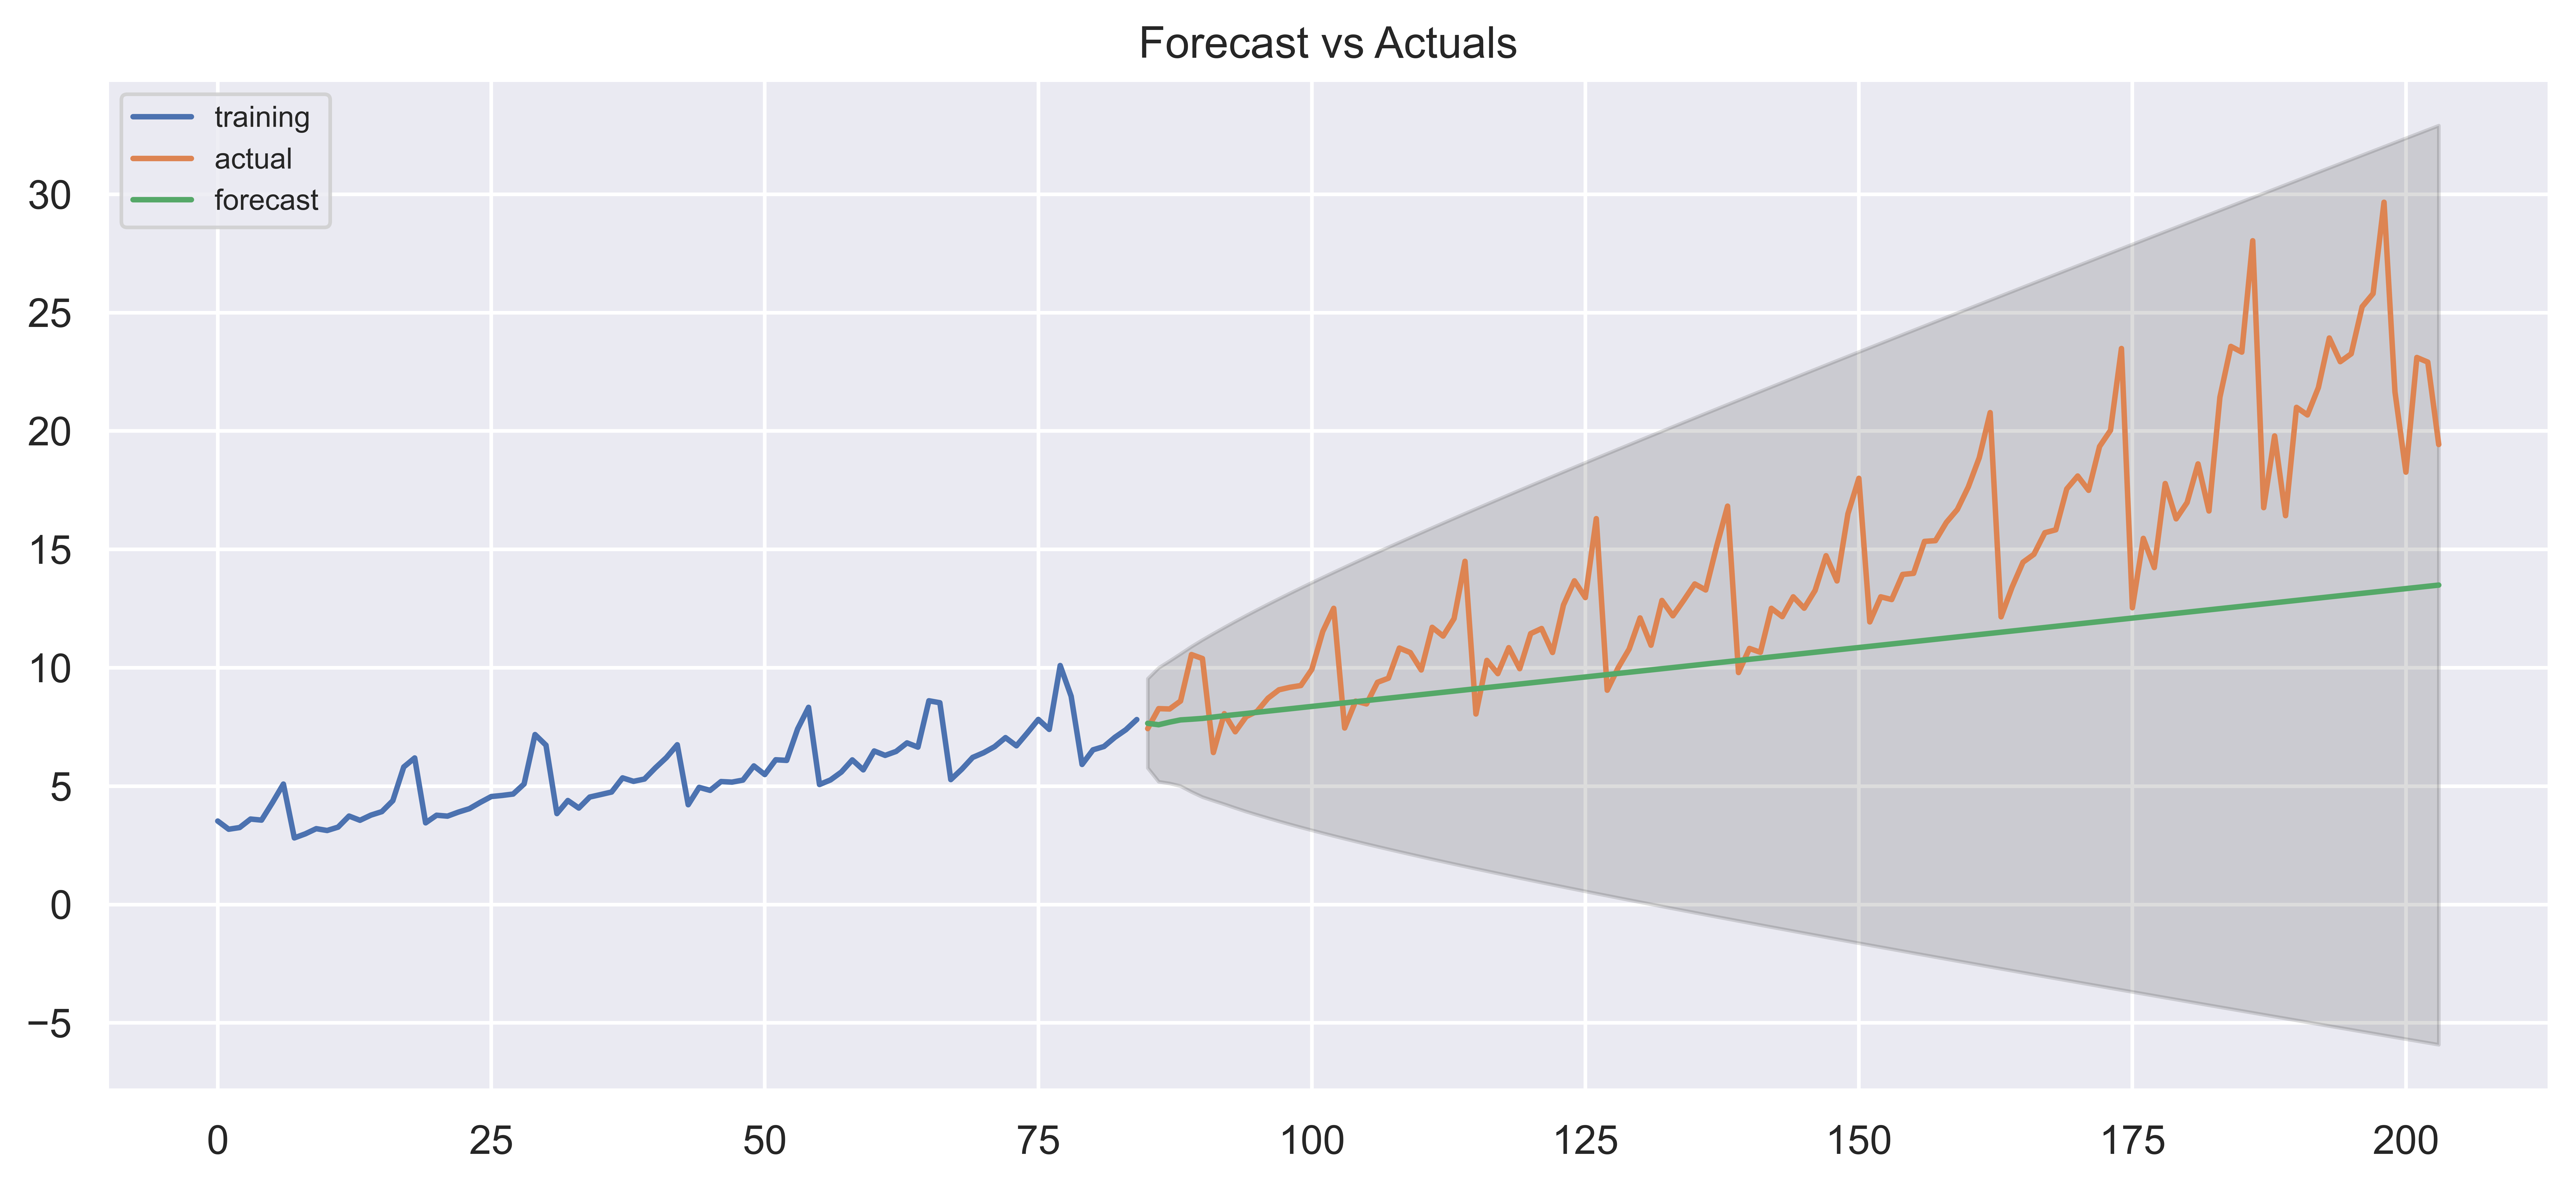

In [18]:
train = df.value[:85]
test = df.value[85:]
# Build Model
model = ARIMA(train.values, order=(3,2,1))  
fitted_3_2_1 = model.fit()

# Forecast
forecast_results = fitted_3_2_1.get_forecast(119) 
fc = forecast_results.predicted_mean
conf_int = forecast_results.conf_int(alpha=0.05)  # alpha=0.05 for 95% CI

lower_ci = pd.Series([i[0] for i in conf_int], index = test.index)
upper_ci = pd.Series([i[1] for i in conf_int], index = test.index)

fc_series = pd.Series(fc, index=test.index)
# Make as pandas series
plt.figure(figsize=(12,5), dpi=1000)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.fill_between(lower_ci.index, lower_ci, upper_ci, color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [19]:
print(fitted_3_2_1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   85
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -116.886
Date:                Thu, 08 Feb 2024   AIC                            243.771
Time:                        16:11:12   BIC                            255.865
Sample:                             0   HQIC                           248.630
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2204      0.194     -1.138      0.255      -0.600       0.159
ar.L2         -0.3436      0.141     -2.443      0.015      -0.619      -0.068
ar.L3         -0.0934      0.252     -0.370      0.7

In [20]:
print(fitted_1_1_1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   85
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -112.630
Date:                Thu, 08 Feb 2024   AIC                            231.260
Time:                        16:11:48   BIC                            238.552
Sample:                             0   HQIC                           234.191
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4213      0.246      1.709      0.087      -0.062       0.904
ma.L1         -0.8659      0.125     -6.943      0.000      -1.110      -0.621
sigma2         0.8485      0.098      8.635      0.0

In [21]:
pd.DataFrame({'AIC':[fitted_1_1_1.aic, fitted_3_2_1.aic], 'BIC':[fitted_1_1_1.bic, fitted_3_2_1.bic]}, index= ['ARIMA(1,1,1)', 'ARIMA(3,2,1)'])

AIC         BIC
ARIMA(1,1,1)  231.259595  238.552046
ARIMA(3,2,1)  243.771071  255.865274

In [24]:
pip install pmdarima

   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   --- ------------------------------------ 61.4/614.7 kB 1.1 MB/s eta 0:00:01
   ------- -------------------------------- 112.6/614.7 kB 1.3 MB/s eta 0:00:01
   ------- ------------------------------ 122.9/614.7 kB 901.1 kB/s eta 0:00:01
   -------- ----------------------------- 143.4/614.7 kB 944.1 kB/s eta 0:00:01
   --------- ---------------------------- 153.6/614.7 kB 766.6 kB/s eta 0:00:01
   --------- ---------------------------- 153.6/614.7 kB 766.6 kB/s eta 0:00:01
   ------------ ------------------------- 194.6/614.7 kB 620.6 kB/s eta 0:00:01
   ------------- ------------------------ 225.3/614.7 kB 599.0 kB/s eta 0:00:01
   -------------- ----------------------- 235.5/614.7 kB 576.2 kB/s eta 0:00:01
   -------------- ----------------------- 235.5/614.7 kB 576.2 kB/s eta 0:00:01
   --------------- ---------------------- 256.0/614.7 kB 52


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import pmdarima as pm

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=874.416, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1602.665, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=913.571, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1392.713, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=865.809, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=867.147, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=871.437, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=868.483, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=858.292, Time=0.32 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=859.374, Time=0.24 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=860.867, Time=0.34 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  204
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -423.146
Date:                Thu, 08 Feb 2024   AIC                            858.292
Time:                        16:16:23   BIC                            878.201
Sample:                             0   HQIC                           866.345
                                - 204                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3669      0.104      3.535      0.000       0.163       0.570
ar.L2          0.9964      0.038     26.240      0.000       0.922       1.071
ar.L3         -0.3639      0.090     -4.048      0.000      -0.540      -0.188
ma.L1          0.1395      0.089      1.564      0.118      -0.035       0.314
ma.L2         -0.8205      0.070    -11.733      0.000      -0.958      -0.683
sigma2         3.6034      0.310     11.640      0.000       2.997       4.210
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):               119.30
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               9.49   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""